# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from prophet import Prophet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Data Science Portfolio/Sales Forecasting/

/content/drive/MyDrive/Data Science Portfolio/Sales Forecasting


# Load Sales Data

In [6]:
sales_df = pd.read_csv("sales_train.csv")
sales_df

<ipython-input-6-1c8feea731f5>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("sales_train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [7]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
sales_df.describe()
# avg sales/day = 5773 Euros, min sales/day = 0, max sales per day = 41551
# avg number of customers = 633, min number of customers = 0, max number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
# Id: transaction ID (combination of Store and date)
# Store: unique store Id
# Sales: sales/day, this is the target variable
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

# Load Store Data

In [10]:
# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [11]:
store_df = pd.read_csv("/content/drive/MyDrive/Data Science Portfolio/Sales Forecasting/sales_store.csv")
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [12]:
# competition distance is 5404 meters away
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [13]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


<Axes: >

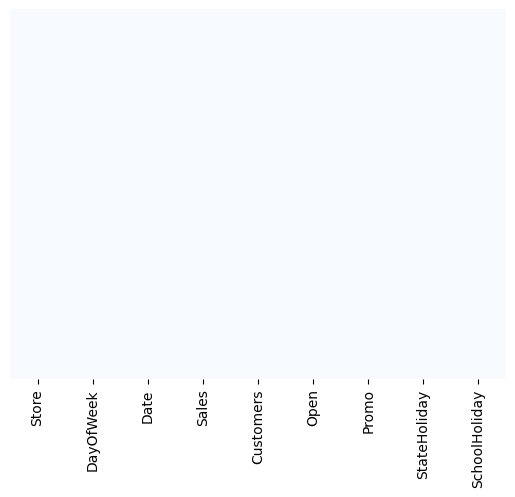

In [14]:
# check for null values
sns.heatmap(sales_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

# EDA

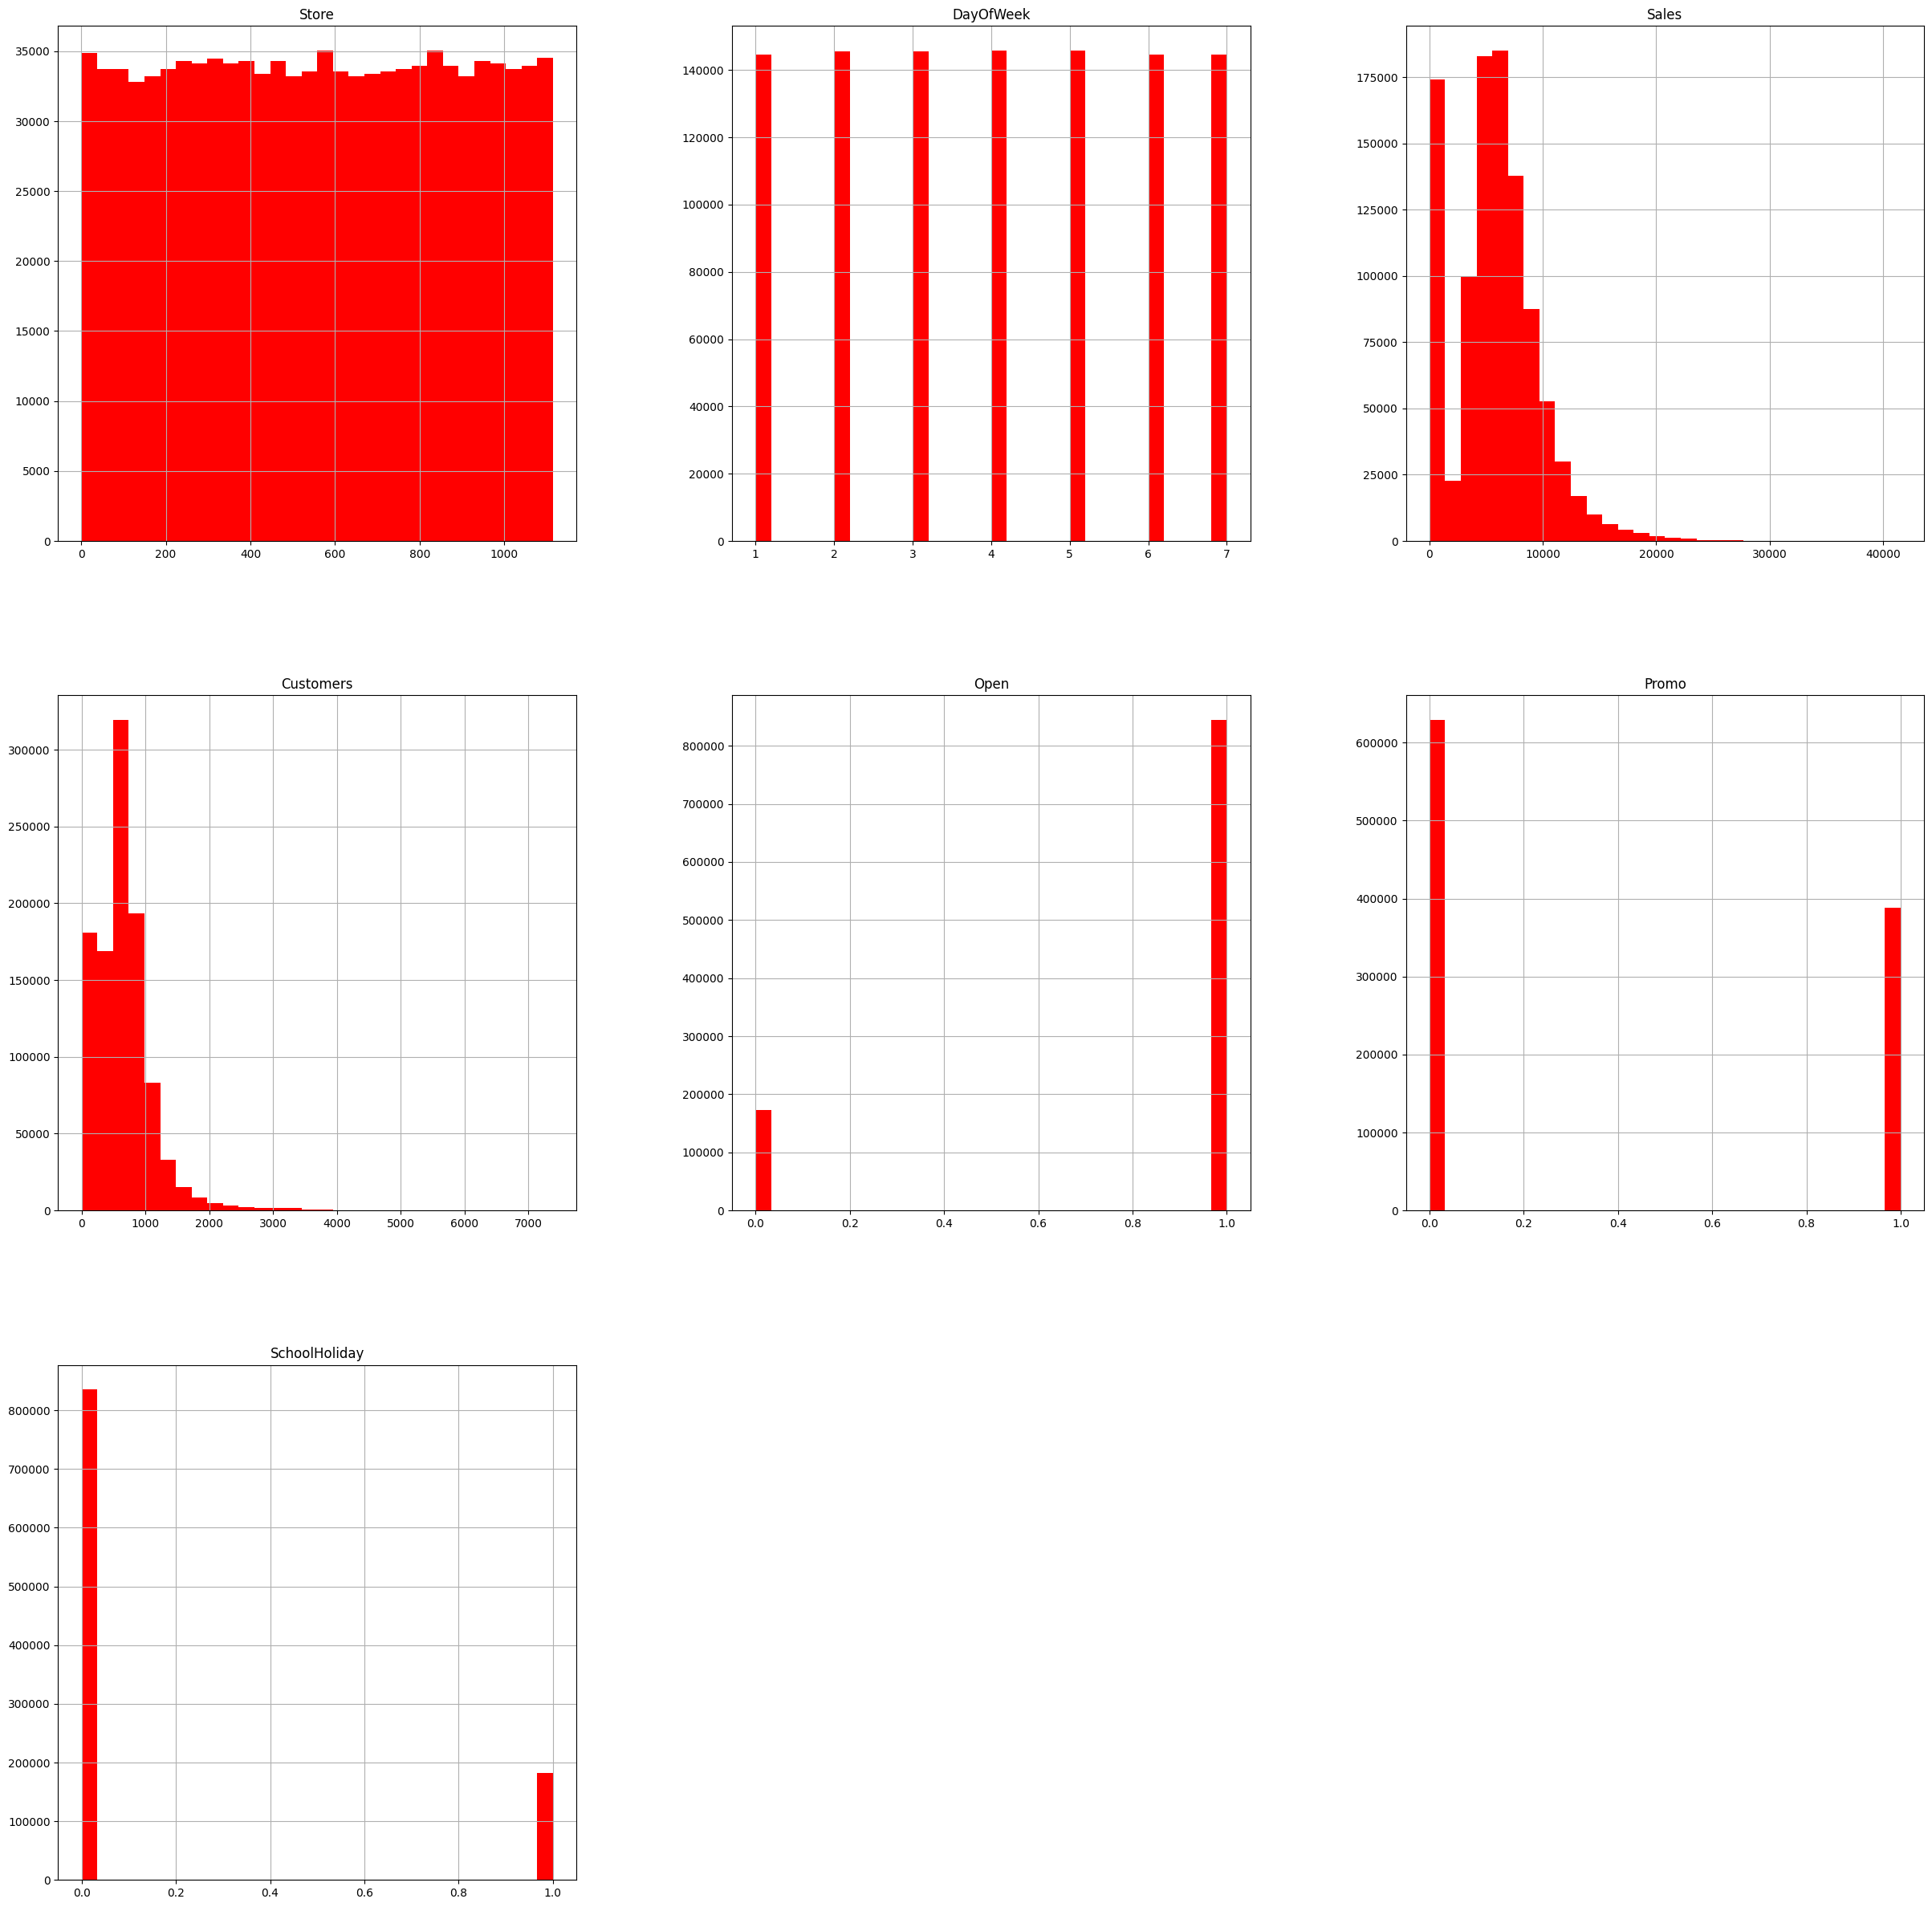

In [15]:
sales_df.hist(bins = 30, figsize = (30,30), color = 'r' )
plt.show()
# data is equally distributed among all stores
# data is equally distibuted across the week
# stores are open most of the time
# average sales around 5000-6000 Euros
# promo #1 was running ~40% of the time
# school holidays are around 20% of the time

In [ ]:
# how many stores are open and closed
print("Total=",len(sales_df))
open_df = sales_df[sales_df["Open"] == 1]
print("number of open stores =", len(open_df))
closed_df = sales_df[ sales_df["Open"] == 0]
print("number of closed stores =", len(closed_df))

Total= 1017209
number of open stores = 844392
number of closed stores = 172817


In [ ]:
sales_df = sales_df[sales_df["Open"] == 1]
sales_df.reset_index(inplace = True)

In [ ]:
# drop the 'Open' column
sales_df.drop(["Open"], axis = 1, inplace = True)

<ipython-input-79-891c546ee085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.drop(["Open"], axis = 1, inplace = True)


<Axes: >

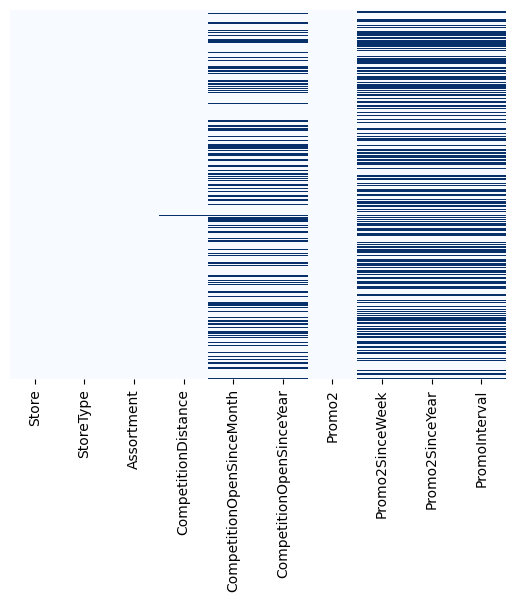

In [ ]:
# check for null values
sns.heatmap(store_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [ ]:
# 3 rows are missing
store_df[store_df["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# 354 rows are missing
store_df[store_df["CompetitionOpenSinceMonth"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_df[store_df["Promo2"] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
cols = ["Promo2SinceWeek" , "Promo2SinceYear" , "PromoInterval" , "CompetitionOpenSinceYear" , "CompetitionOpenSinceMonth"]

In [ ]:
# filling missing values with zeros
store_df[cols] = store_df[cols].fillna(0)

In [ ]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
1112,1113,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
1113,1114,a,c,870.0,0.0,0.0,0,0.0,0.0,0


<Axes: >

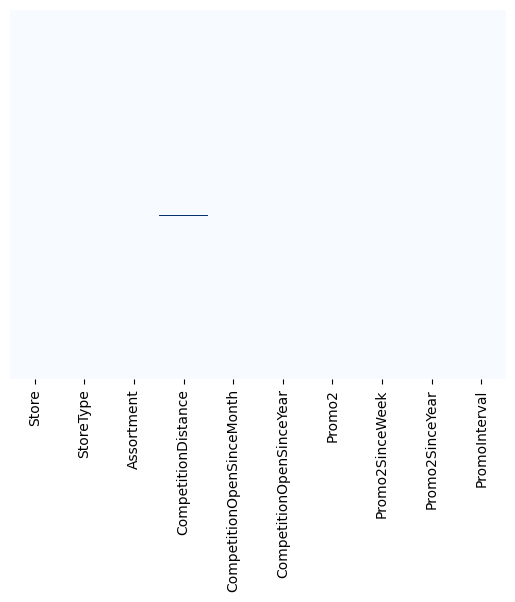

In [ ]:
sns.heatmap(store_df.isnull() , yticklabels = False, cbar = False, cmap = 'Blues' )

In [ ]:
# filling missing values in 'CompetitionDistance' with their median
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median() , inplace = True)

<Axes: >

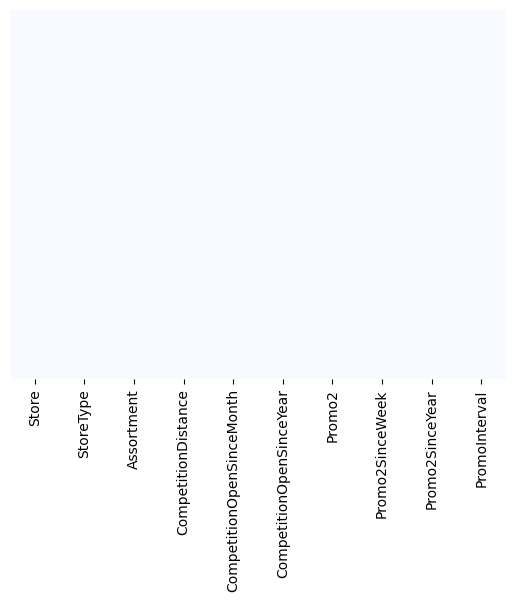

In [ ]:
sns.heatmap(store_df.isnull() , yticklabels = False, cbar = False, cmap = 'Blues' )

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

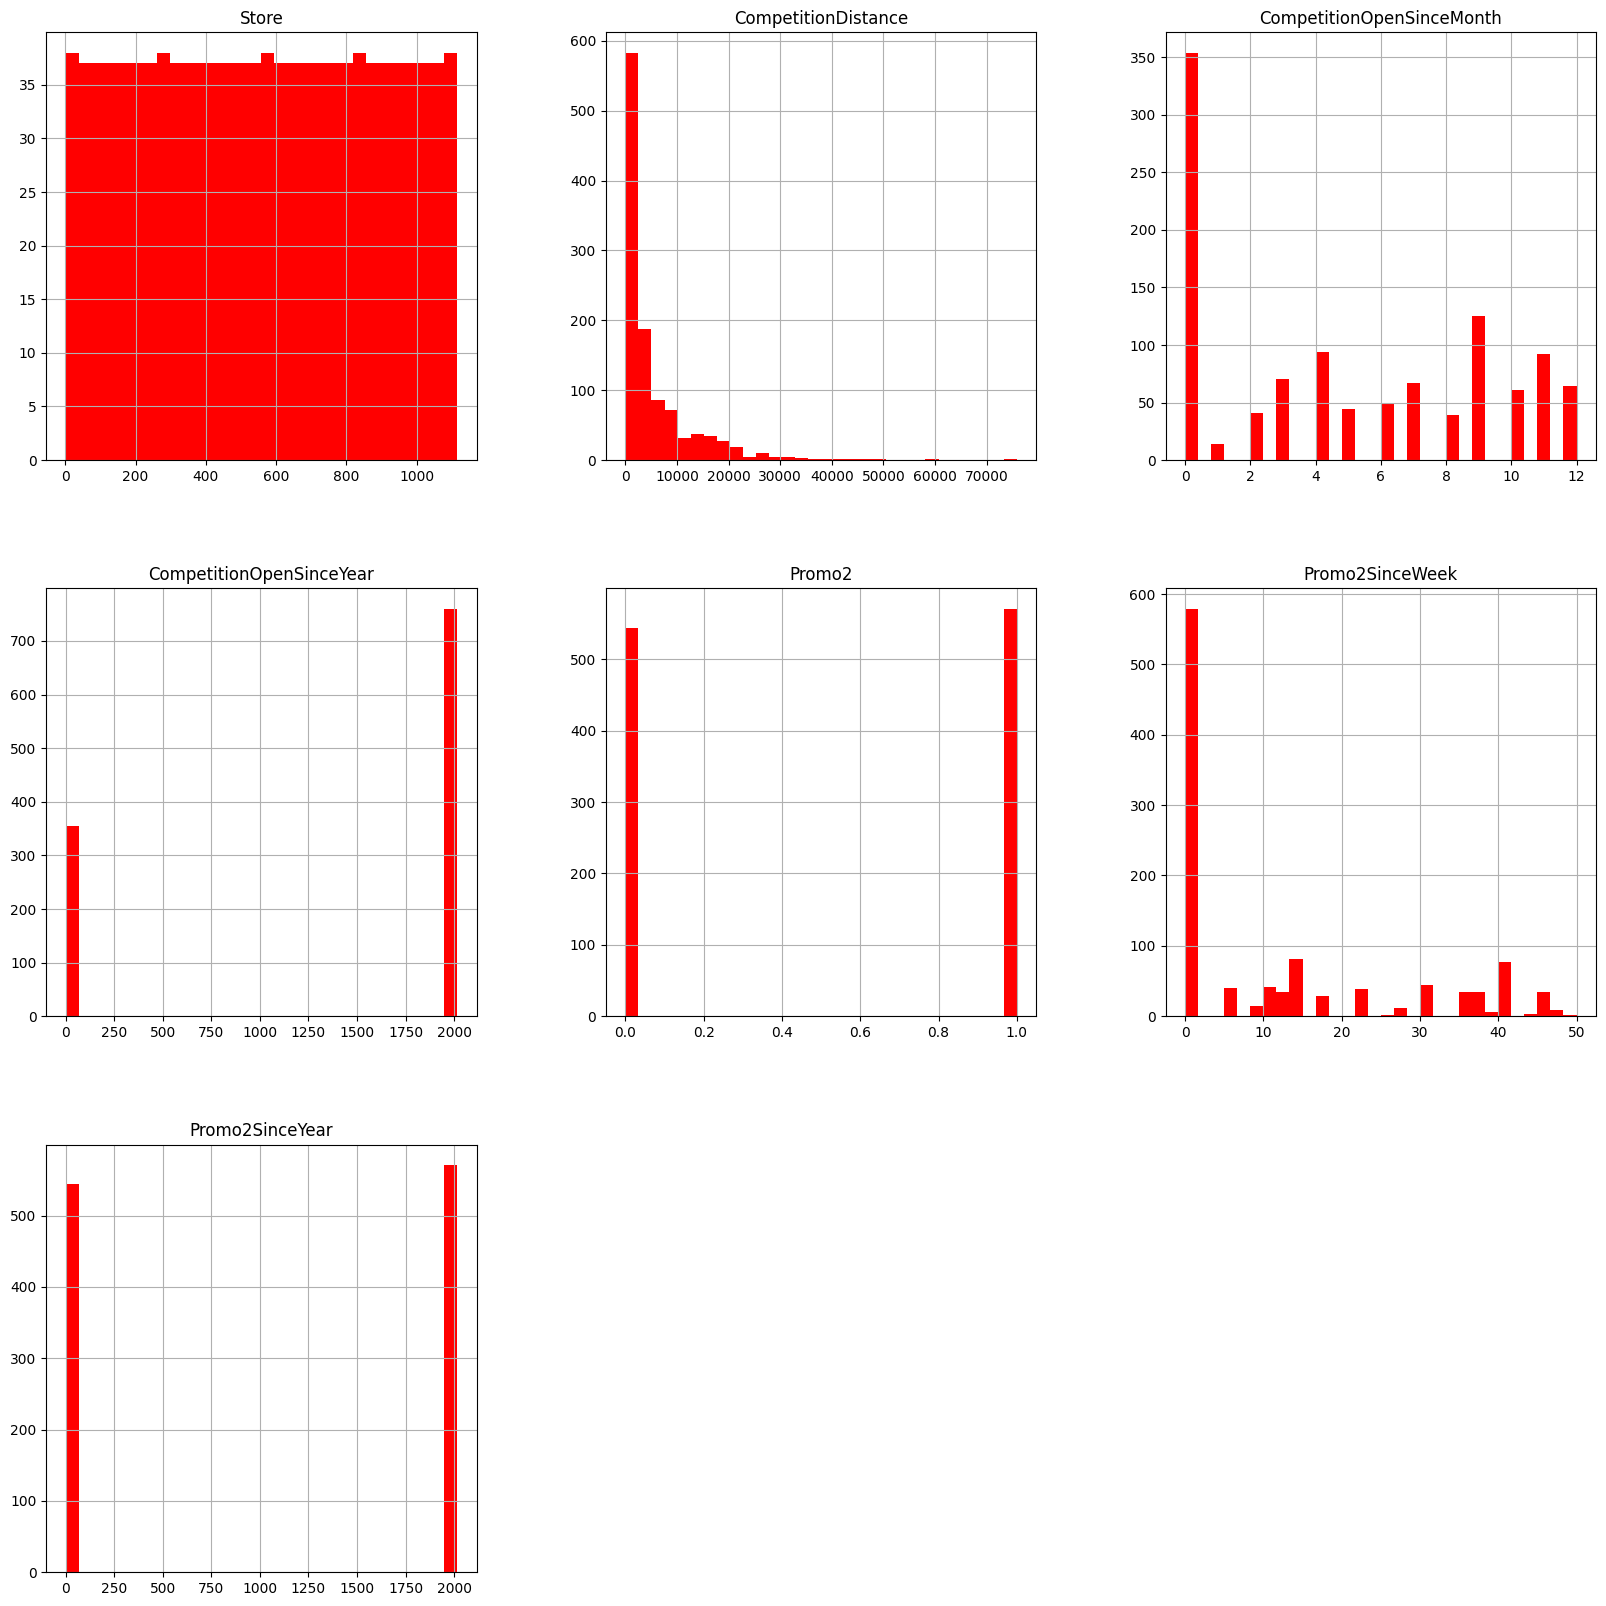

In [ ]:
store_df.hist(bins = 30, figsize = (20,20), color = 'r' )
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m

In [ ]:
# merge both data frames together based on 'Store'
df = pd.merge(sales_df , store_df, on = 'Store', how = 'inner')

In [ ]:
correlations = df.corr()['Sales'].sort_values()
correlations
# customers and promo are positively correlated with the sales
# Promo2 is not effective at all

<ipython-input-95-81a81c46372d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['Sales'].sort_values()


DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
index                       -0.062679
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.035851
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

<ipython-input-119-a13489a60cd4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()


<Axes: >

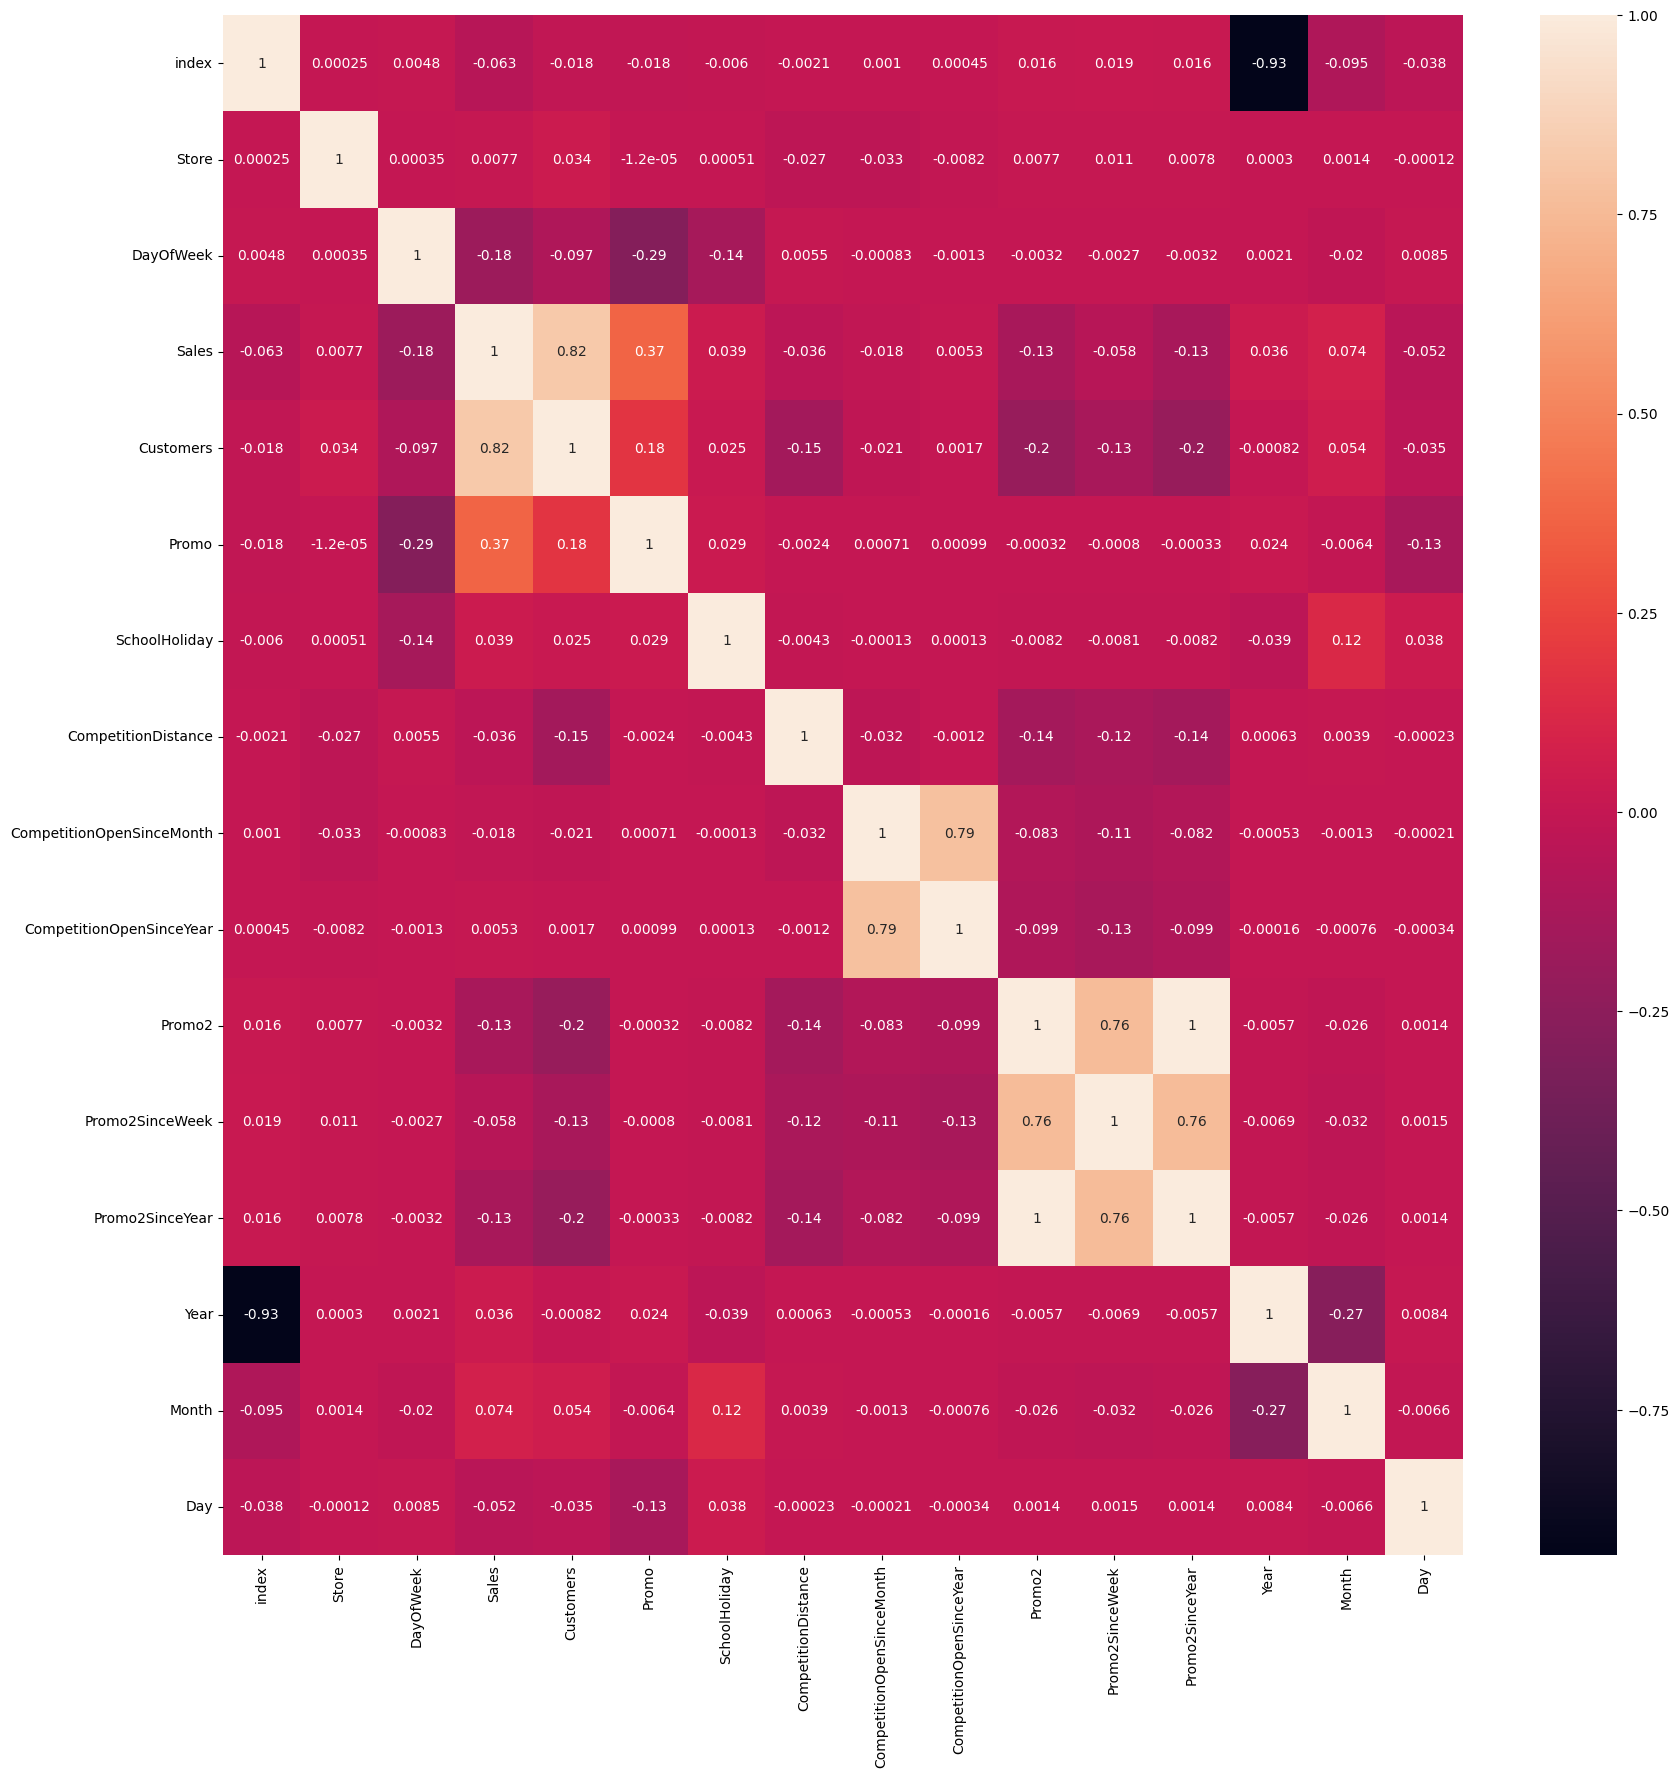

In [ ]:
correlations = df.corr()
f, ax = plt.subplots(figsize=[20, 20])
sns.heatmap(correlations, annot = True)
# customers and sales are strongly correlated

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [ ]:
df

,index,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,0,1,5,2015-07-31,5263,555,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1115,1,4,2015-07-30,5020,546,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,2230,1,3,2015-07-29,4782,523,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,3345,1,2,2015-07-28,5011,560,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,4460,1,1,2015-07-27,6102,612,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1009696,292,1,2013-01-07,9291,1002,1,0,0,a,...,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,1011926,292,6,2013-01-05,2748,340,0,0,0,a,...,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,1013041,292,5,2013-01-04,4202,560,0,0,1,a,...,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,1014156,292,4,2013-01-03,4580,662,0,0,1,a,...,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


Text(0.5, 1.0, 'Average Customers Per Month')

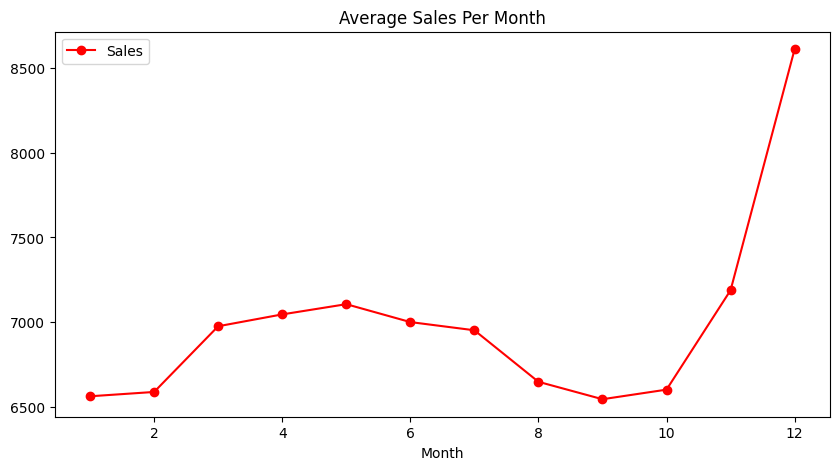

<Figure size 640x480 with 0 Axes>

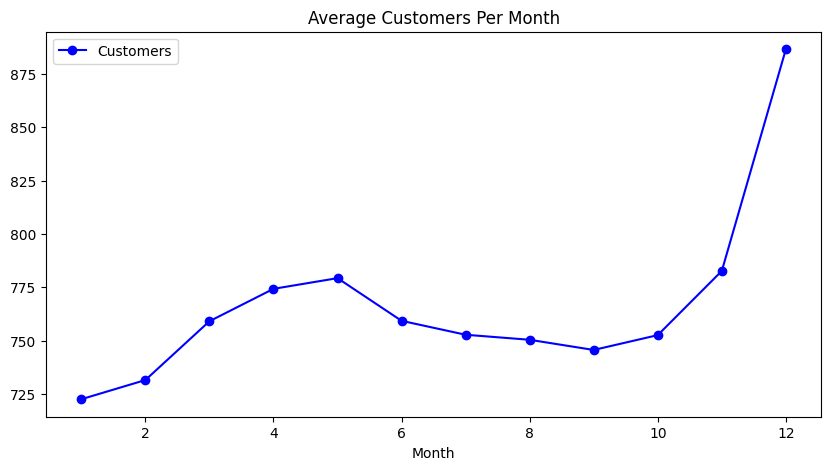

In [ ]:
# average sales and number of customers per month
# sales and number of customers around December(christmas)
axis = df.groupby("Month").agg({
    "Sales":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'r')

axis.set_title("Average Sales Per Month")

plt.figure()
axis = df.groupby("Month").agg({
    "Customers":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'b')

axis.set_title("Average Customers Per Month")

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

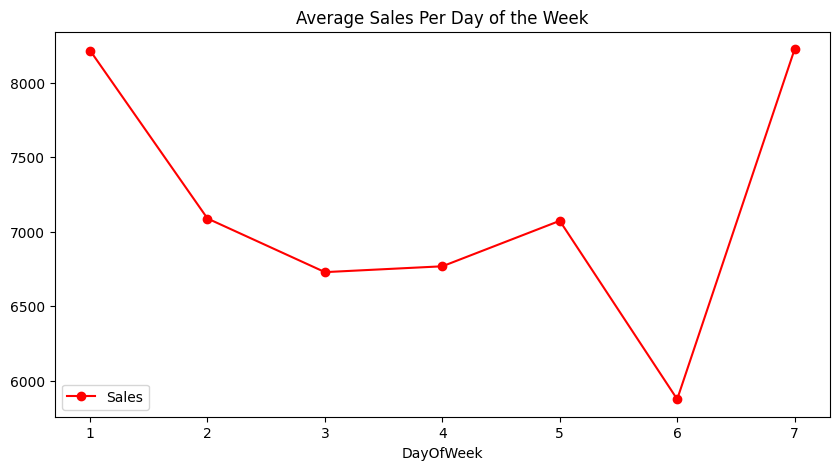

<Figure size 640x480 with 0 Axes>

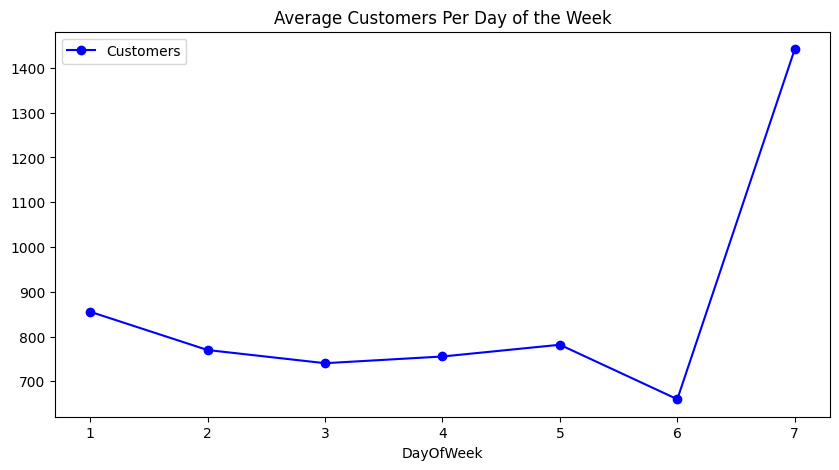

In [ ]:
# average sales and number of customers per day
axis = df.groupby("DayOfWeek").agg({
    "Sales":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'r')

axis.set_title("Average Sales Per Day of the Week")

plt.figure()
axis = df.groupby("DayOfWeek").agg({
    "Customers":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'b')

axis.set_title("Average Customers Per Day of the Week")

Text(0.5, 1.0, 'Average Customers Per Day of Week')

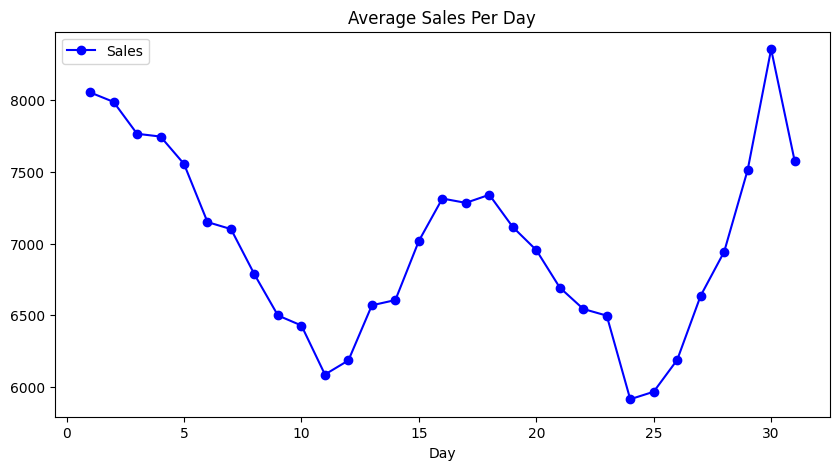

<Figure size 640x480 with 0 Axes>

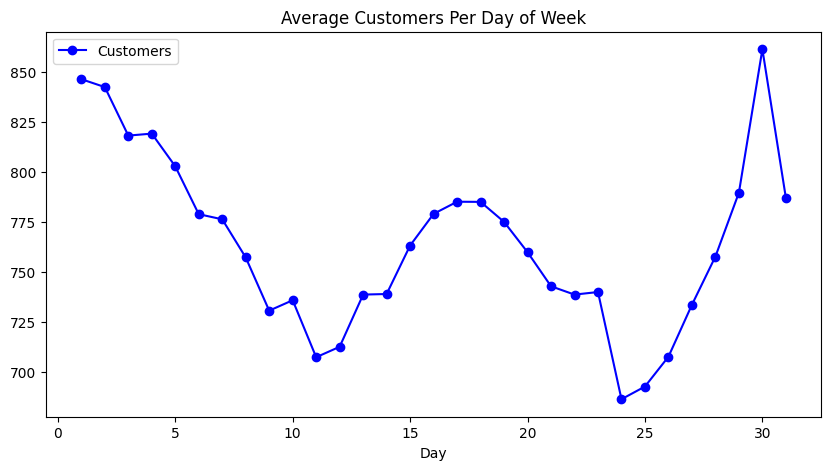

In [ ]:
# sales and customers per day of the month
# most customers and sales are around 30th and 1st of the month
# min number of customers are around the 24th of the month
axis = df.groupby("Day").agg({
    "Sales":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'b')

axis.set_title("Average Sales Per Day")

plt.figure()
axis = df.groupby("Day").agg({
    "Customers":"mean"
}).plot(figsize = (10,5), marker = 'o', color = 'b')

axis.set_title("Average Customers Per Day of Week")

<Axes: xlabel='Date'>

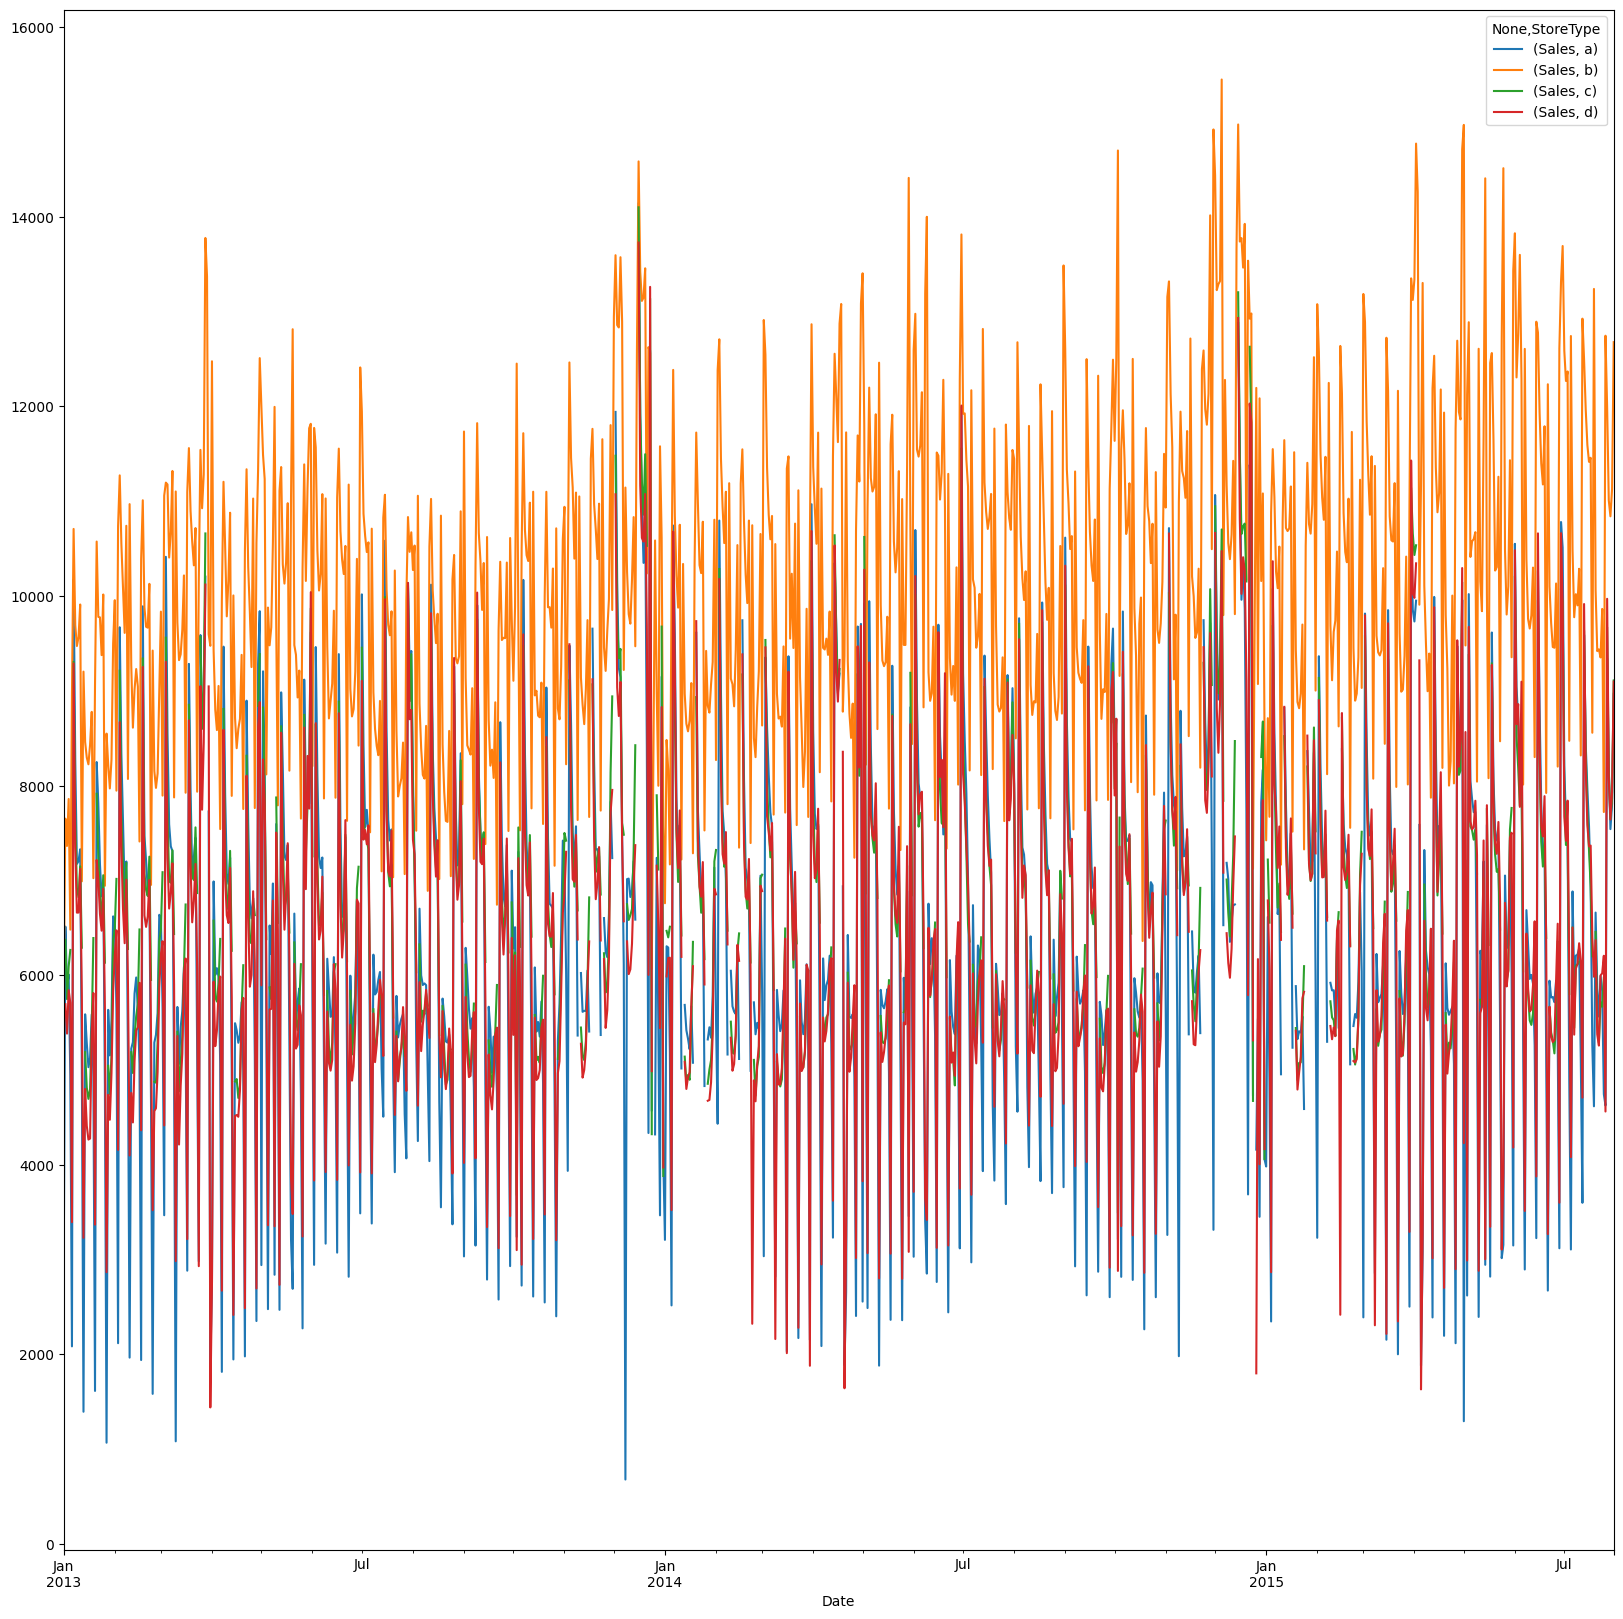

In [ ]:
# store b has the highest sales
df.groupby(["Date" , "StoreType"]).agg({"Sales":"mean"}).unstack().plot(figsize=(20,20))

<Axes: xlabel='Promo', ylabel='Customers'>

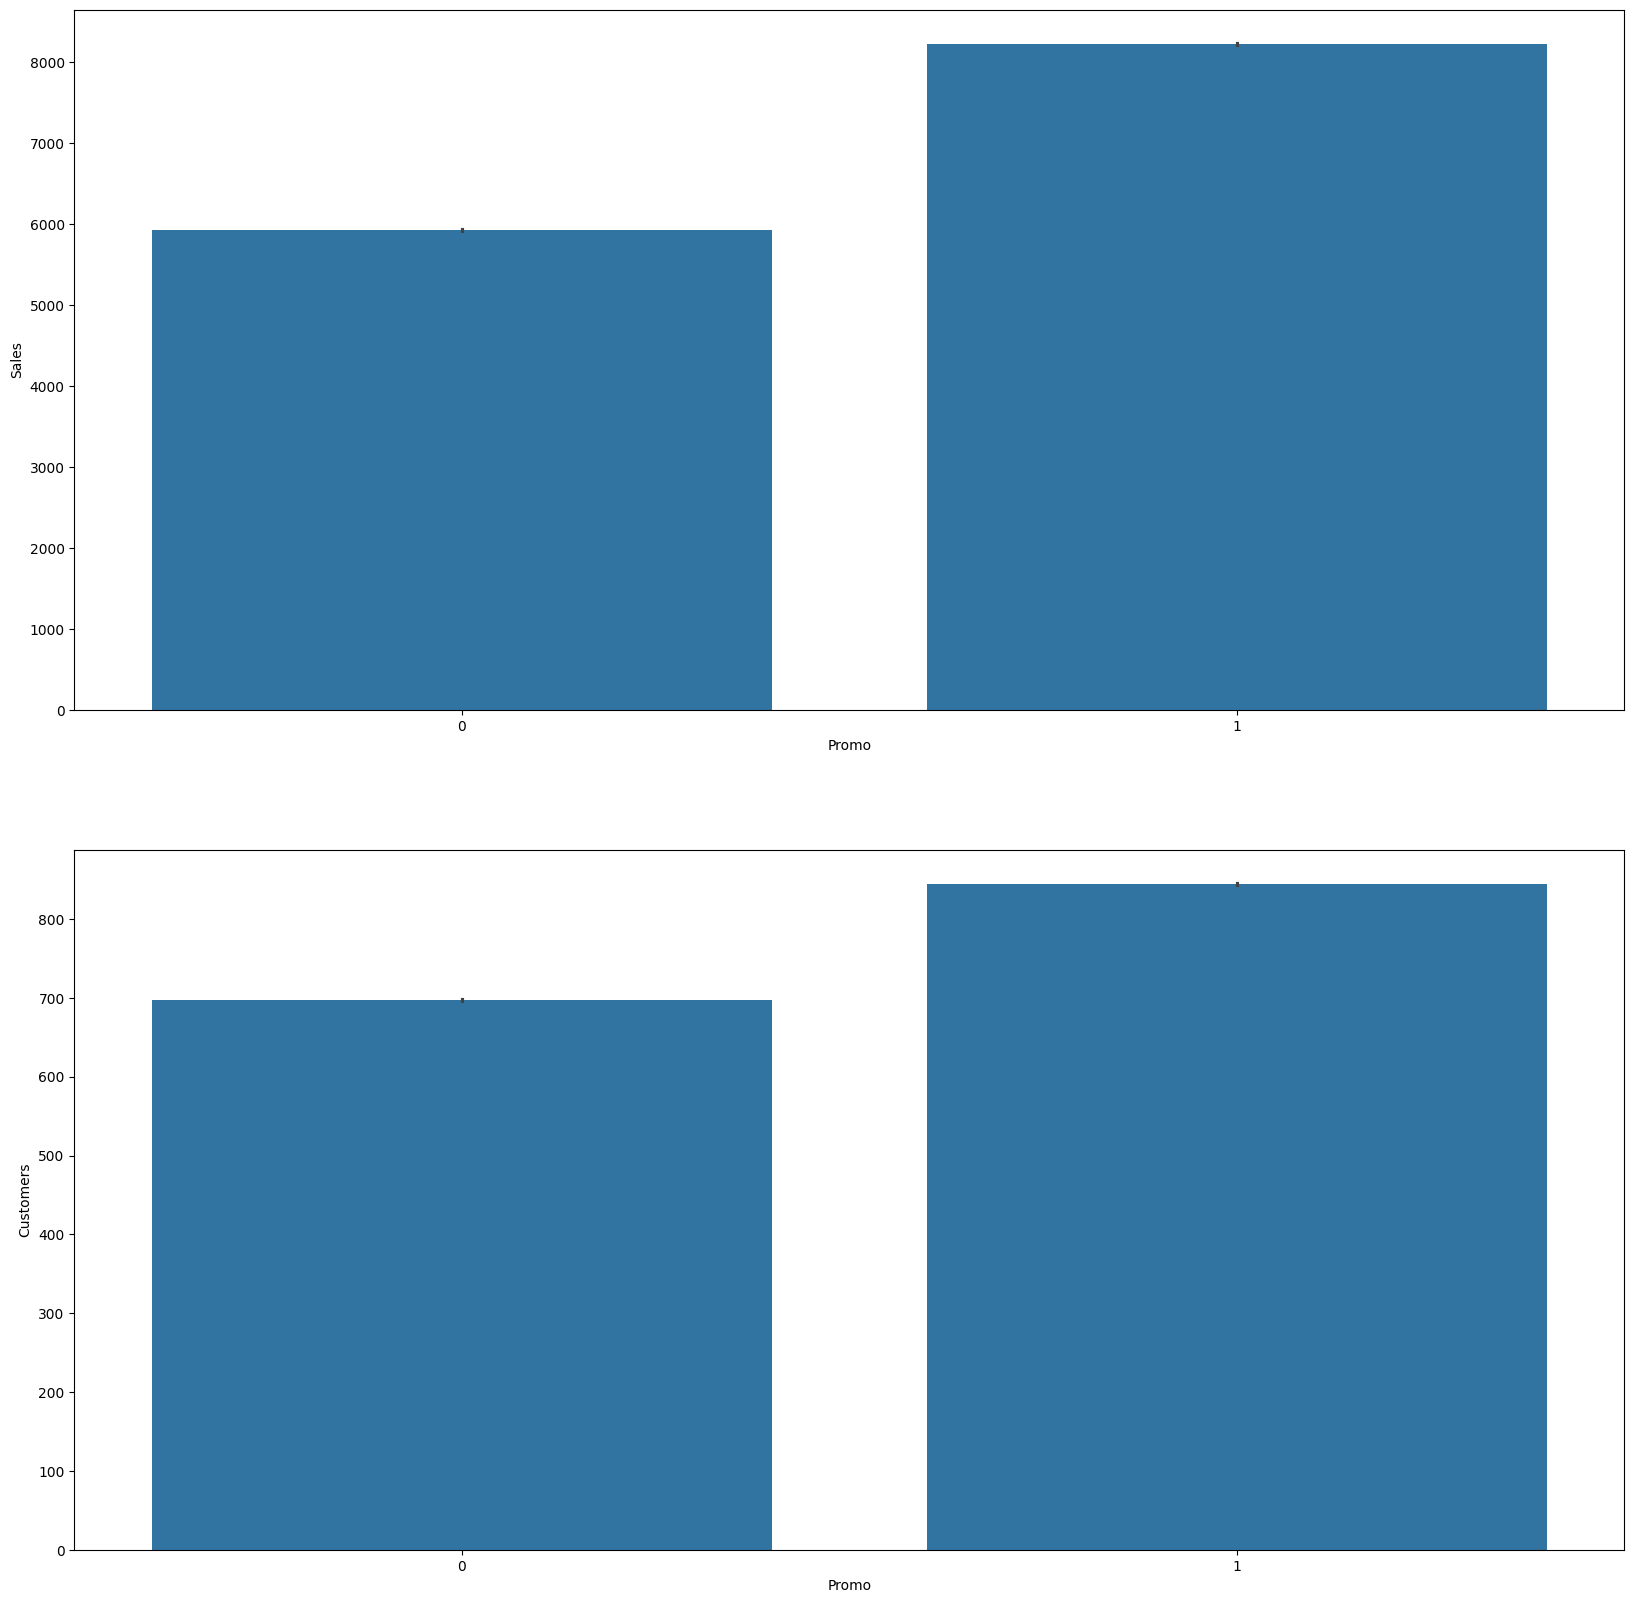

In [ ]:
# sales & customers goes up by applying promo
plt.figure(figsize=[20,20])

plt.subplot(211)
sns.barplot(x = 'Promo', y = "Sales", data = df)
plt.subplot(212)
sns.barplot(x = 'Promo', y = "Customers", data = df)

In [ ]:
# plt.figure(figsize=[20,20])

# plt.subplot(211)
# sns.violinplot(x = "Promo", y = "Sales", data = df)
# plt.subplot(212)
# sns.violinplot(x = "Customers", y = "Sales", data = df)

# Model

In [ ]:
# function to make time series predictions
def sales_predictions(store_id, sales_df, periods):
    sales_df = sales_df[sales_df["Store"] == store_id]
    sales_df = sales_df[['Date', "Sales"]].rename(columns = {"Date":"ds", "Sales":'y'})
    sales_df = sales_df.sort_values("ds")
    model = Prophet()
    model.fit(sales_df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure = model.plot(forecast , xlabel = "Date", ylabel = "Sales")
    figure2 = model.plot_components(forecast)
    return sales_df

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9m885l9/lqv5r484.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9m885l9/enz0gx1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23916', 'data', 'file=/tmp/tmpb9m885l9/lqv5r484.json', 'init=/tmp/tmpb9m885l9/enz0gx1g.json', 'output', 'file=/tmp/tmpb9m885l9/prophet_modelcro_vyjf/prophet_model-20240130092105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,y
7819,2013-01-02,4812
7818,2013-01-03,4675
7817,2013-01-04,5114
7816,2013-01-05,4256
7815,2013-01-07,7804
...,...,...
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186


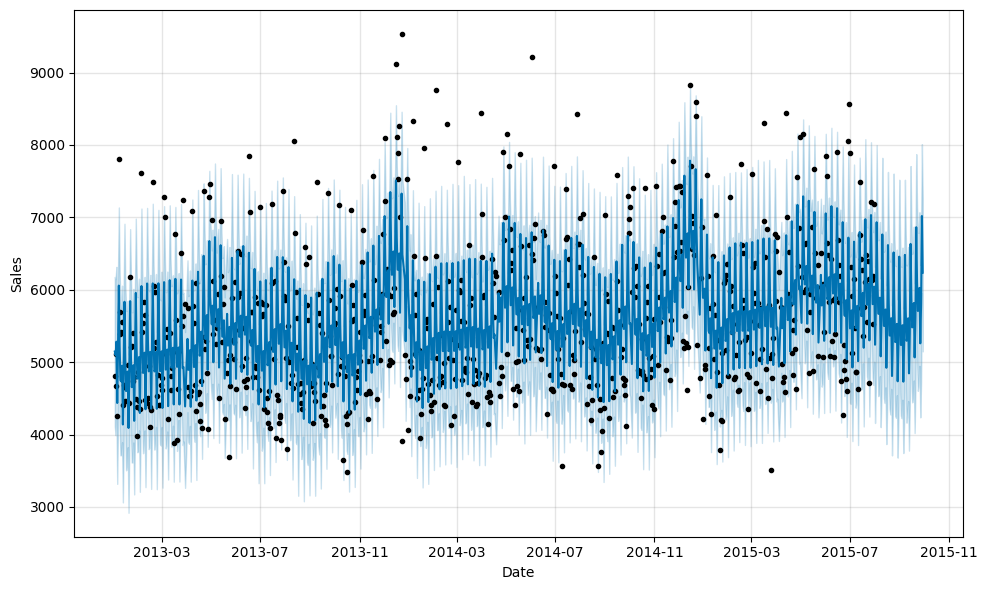

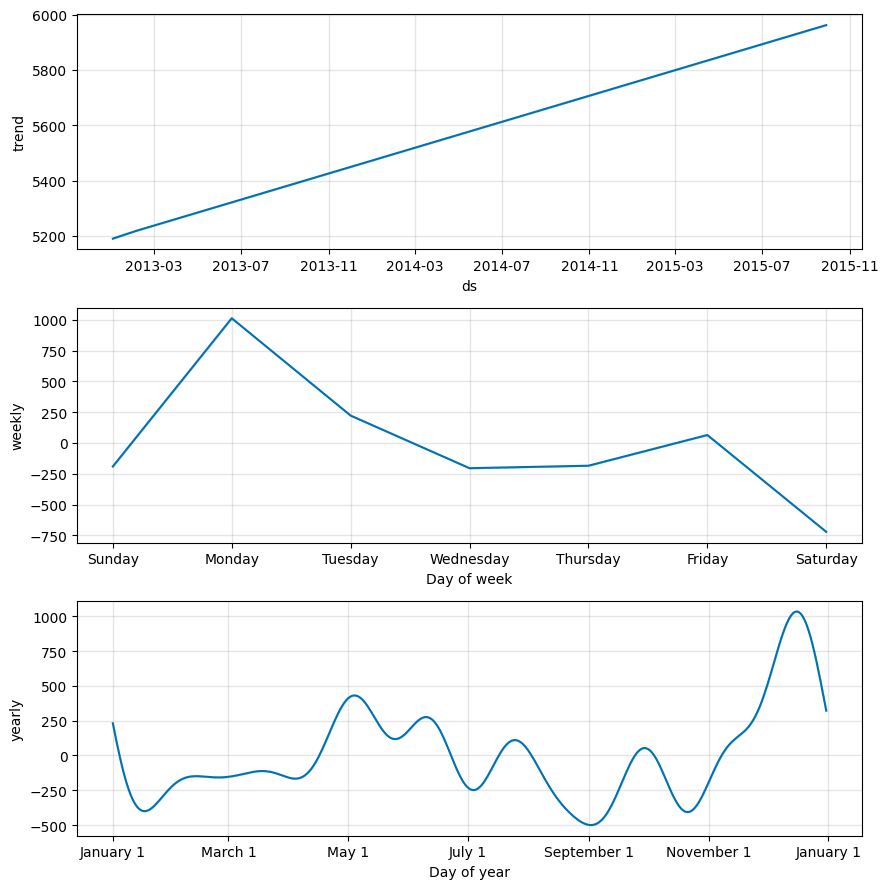

In [ ]:
# prediction for store id no.10 and for 60 days
sales_predictions(10, df, 60)

In [ ]:
# function to make time series predictions taking holidays into consideration
def sales_predictions(store_id, sales_df, periods, holidays):
    sales_df = sales_df[sales_df["Store"] == store_id]
    sales_df = sales_df[['Date', "Sales"]].rename(columns = {"Date":"ds", "Sales":'y'})
    sales_df = sales_df.sort_values("ds")
    model = Prophet(holidays = holidays)
    model.fit(sales_df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure = model.plot(forecast , xlabel = "Date", ylabel = "Sales")
    figure2 = model.plot_components(forecast)
    return sales_df


In [ ]:
# get dates of school holidays
school_holidays = df[df['SchoolHoliday'] == 1]['Date'].values
school_holidays

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', ...,
       '2013-01-04T00:00:00.000000000', '2013-01-03T00:00:00.000000000',
       '2013-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
# get dates of state holidays
state_holidays = df[(df['StateHoliday'] == 'a') | (df['StateHoliday'] == 'b') | (df['StateHoliday'] == 'c')]['Date'].values
state_holidays

array(['2014-10-03T00:00:00.000000000', '2013-10-03T00:00:00.000000000',
       '2015-06-04T00:00:00.000000000', '2014-06-19T00:00:00.000000000',
       '2013-05-30T00:00:00.000000000', '2015-06-04T00:00:00.000000000',
       '2014-06-19T00:00:00.000000000', '2013-05-30T00:00:00.000000000',
       '2014-10-03T00:00:00.000000000', '2013-10-03T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2014-10-31T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2013-10-03T00:00:00.000000000',
       '2013-05-01T00:00:00.000000000', '2015-06-04T00:00:00.000000000',
       '2014-06-19T00:00:00.000000000', '2013-05-30T00:00:00.000000000',
       '2015-06-04T00:00:00.000000000', '2014-06-19T00:00:00.000000000',
       '2013-05-30T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2015-06-04T00:00:00.000000000', '2014-06-19T00:00:00.000000000',
       '2013-05-30T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2015-05-25

In [ ]:
# create dataframe for state holidays
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                              'holiday':'state_holiday'})

In [ ]:
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [ ]:
# create dataframe for school holidays
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                              'holiday':'school_holiday'})

In [ ]:
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [ ]:
# concatenating school & state holidays
school_state_holidays = pd.concat((state_holidays, school_holidays))

In [ ]:
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9m885l9/gwezdicv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9m885l9/s98p6ztj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68243', 'data', 'file=/tmp/tmpb9m885l9/gwezdicv.json', 'init=/tmp/tmpb9m885l9/s98p6ztj.json', 'output', 'file=/tmp/tmpb9m885l9/prophet_modelyauu4bmy/prophet_model-20240130092127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,y
7819,2013-01-02,4812
7818,2013-01-03,4675
7817,2013-01-04,5114
7816,2013-01-05,4256
7815,2013-01-07,7804
...,...,...
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186


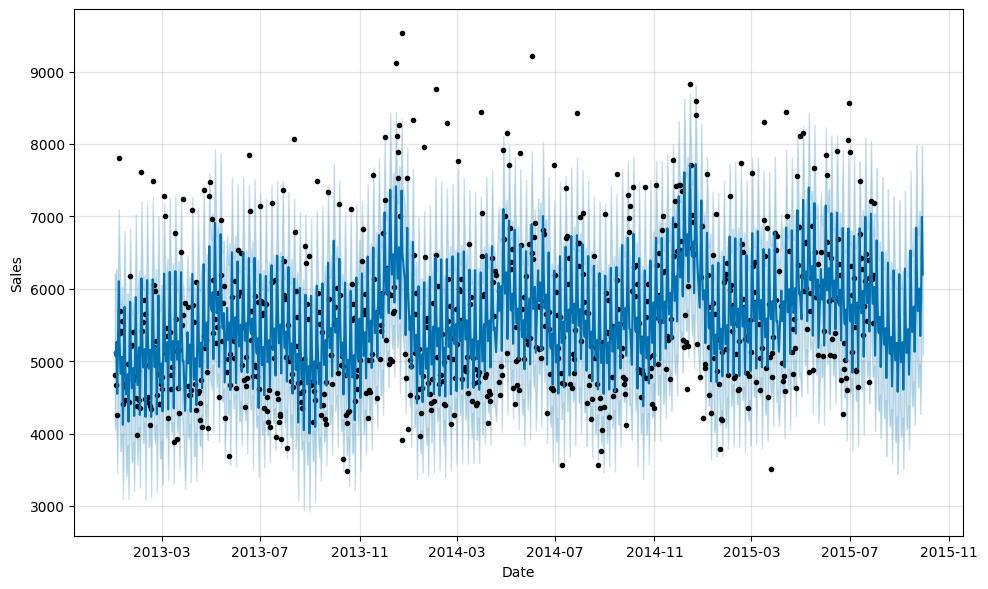

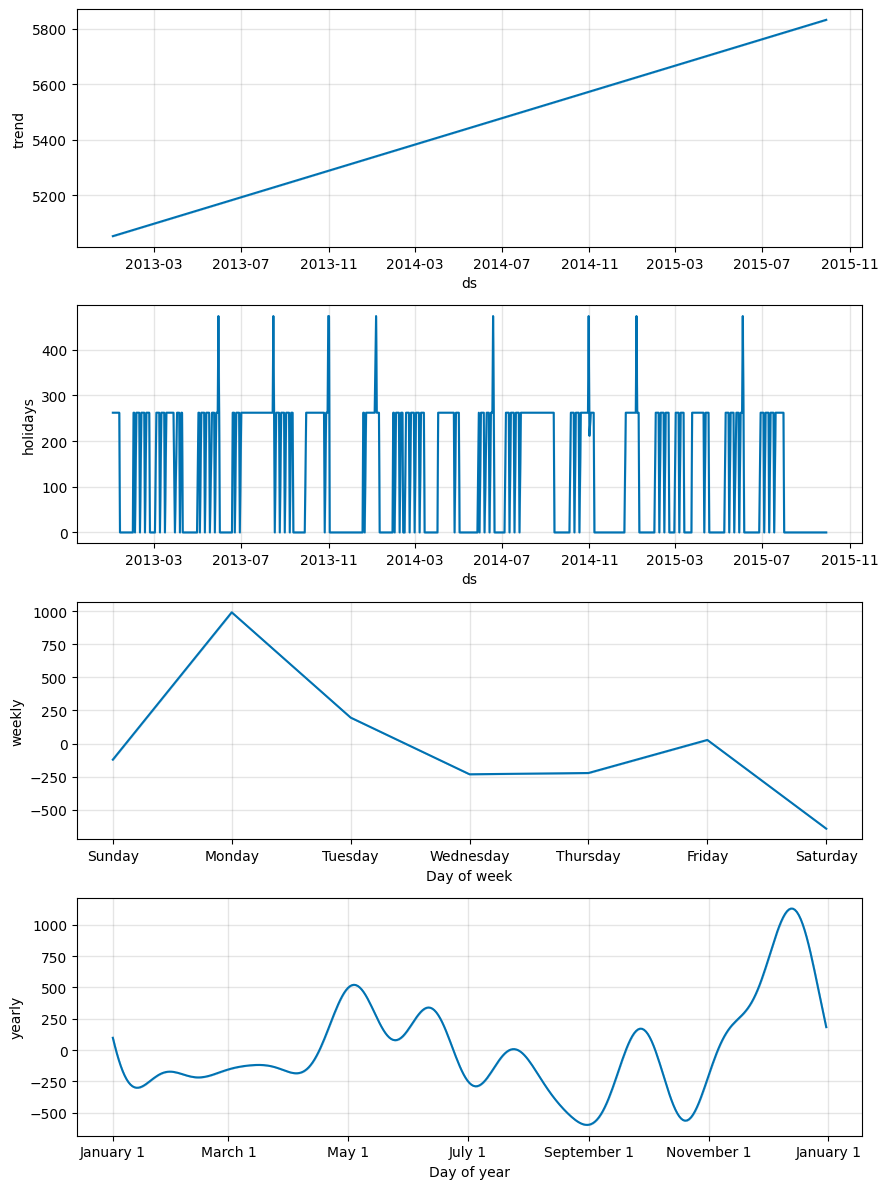

In [ ]:
# prediction for store id no.10 and for 60 days taking in consideration holidays
sales_predictions(10, df, 60, school_state_holidays)